In [42]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [43]:
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print(DEVICE)

mps


In [ ]:
# transform = transforms.ToTensor()
# train_DS = datasets.MNIST(root = '/Users/sanghyun/Desktop/GIT_Folder', train=True, download=True, transform=transform)
# test_DS = datasets.MNIST(root  = '/Users/sanghyun/Desktop/GIT_Folder', train=False, download=True, transform=transform)

## Train_DS와 test_DS 구경

In [44]:
transform = transforms.ToTensor()
'''
이미지나 NumPy 배열은 (높이, 너비, 채널) 순서이지만
PyTorch 모델은 (채널, 높이, 너비) 순서를 기대.
ToTensor()는 이 순서를 자동으로 조정
'''
train_DS = datasets.MNIST(root = '/Users/sanghyun/Desktop/GIT_Folder', train=True, download=False, transform=transform) # transform -> tensor로 바꿔주는...!
test_DS = datasets.MNIST(root  = '/Users/sanghyun/Desktop/GIT_Folder', train=False, download=False, transform=transform)

In [ ]:
print(train_DS)
print(test_DS)
print(len(train_DS))
print(len(test_DS))

In [ ]:
train_DS.classes

In [ ]:
train_DS.class_to_idx

In [ ]:
train_DS.data.shape
'''
transform을 지정해도, 실제 데이터 꺼낼 때만 적용되는 거고,
내부 데이터 shape은 안 바뀜.
'''

In [ ]:
train_DS.data[0]

In [ ]:
plt.imshow(train_DS.data[0], cmap="gray")
plt.colorbar()

In [ ]:
print(train_DS.targets)
print(train_DS.targets.shape)

## DataLoader 구경

In [45]:
'''
train_DL에서 한 번 뽑으면(=for loop에서 한 번에)
32개의 데이터(=BATCH_SIZE)로 이루어진 미니배치가 나온다.
'''
BATCH_SIZE = 32
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
x_batch, y_batch = next(iter(train_DL)) # 데이터 한 국자 뜨자~

print(type(x_batch))
print(x_batch.shape) # 보면 개 채 행 렬 꼴이다. 32개의 데이터가 1개의 채널 그리고 28 by 28로 이루어져있다.

In [ ]:
plt.imshow(x_batch[0].squeeze(), cmap="gray") # 기존 위에 플롯을 보면 값이 통일 x -> ToTensor()을 쓰니깐 0 ~ 1 사이의 값으로 변환됨.
plt.colorbar()

In [ ]:
print(train_DL.dataset.data.dtype)
print(x_batch.dtype)
print(x_batch.shape)
'''
transform = transforms.ToTensor()에서 .ToTensor()의 역할
1. tensor로 바꿔준다
2. 개채행열로 바꿔준다
3. 0~1 사이로 바꿔준다
'''

## 본격적으로 model 만들기!

In [46]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(28 * 28, 100),
                                    nn.ReLU(),
                                    nn.Linear(100, 10)) # 10개 분류니깐 10개의  출력층


    def forward(self, x):

        x = torch.flatten(x, start_dim=1)
        '''
        nn.Linear(=선형 계층, fully connected layer)는 입력 형태가 (batch, feature), 즉 (배치 개수, 특성 개수)이길 원한다.
        하지만 이미지 데이터는 보통 (배치, 채널, 행, 열)로 들어옴.
        따라서 .flatten으로 (배치, 특성 개수)로 변형 ㄱㄱ
        '''

        x = self.linear(x)

        return x

In [ ]:
# flatten 확인
x_batch, _ = next(iter(train_DL))
print(x_batch.shape)
flat_image = torch.flatten(x_batch)
print(flat_image.shape)

flat_image = torch.flatten(x_batch, start_dim=1) # 개 체 행 렬이면 1번 즉 체부터 펴라... 32 \\ 1 * 28 * 28
print(flat_image.shape)

In [ ]:
model = MLP()
# model.to(DEVICE)
print(model)

#x_batch, y_batch = next(iter(train_DL)) # 일반적인 훈련 루프에서는 안 써도 됨. 이미 위에서 Dataloader에서 batch_size를 설정했으니깐
# print(model(x_batch).shape) -> error -> torch.Size([32, 1, 28, 28]) 이므로 개채행열은데 nn linear은 개채를 원한다!! 즉 flatten을 하자!!
#print(model(x_batch).shape) # 32 , 10 -> 10개의 확룰 32개의 데이터에서

## 모델 훈련시키기!

In [49]:
from torch import optim

LP = 1e-3

EPOCH = 20

criterion = nn.CrossEntropyLoss()

#optimizer = optim.Adam(model.parameters(), lr = LP)

def Train(model, train_DL, criterion, optimizer):

    loss_history = []

    NoT = len(train_DL.dataset)

    model.train()

    for ep in range(EPOCH):

        rloss = 0 # running loss

        for x_batch, y_batch in train_DL: # for SGD

            # GPU
            #x_batch = x_batch.to(DEVICE)   # ← 이 부분이 꼭 필요!
            #y_batch = y_batch.to(DEVICE)

            # inference
            y_hat = model(x_batch)

            # loss
            loss = criterion(y_hat, y_batch)

            # update
            optimizer.zero_grad() # gradient 누적을 막지 위한 초기화 -> 안하면 gradient가 계속 누적돼서 가중치 업데이트가 잘못된다.
            loss.backward() # backpropagation
            optimizer.step() # weight update

            # loss accumulation
            loss_b = loss.item() * x_batch.shape[0]
            '''
            loss.item()은 한 데이터당 평균 손실값
            전체 손실로 바꾸려면 배치 크기인 x_batch.shape[0]을 곱
            '''
            rloss += loss_b  # -> 이렇게 하는 이유 다시 곰곰히 생각해보기

        # print loss
        loss_e = rloss / NoT

        loss_history += [loss_e]

        print(f'Epoch : {ep + 1}, train loss : {round(loss_e, 3)}')
        print("-" * 20)

    return loss_history

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = LP)
Train(model, train_DL, criterion, optimizer)

<hr>

## Cross Entropy 확인(왜 모델에 softmax를 안붙였을까?)

In [ ]:
# cross entropy 구하는 여러가지 방법
import torch.nn.functional as F

y_hat = torch.randn(3, 5) # data는 (배치 수, feature 수 (개, 채)) 5 종류러 분류하는 문제 가정

print(y_hat) # 가로 축으로 합ㅂ이 1이 아님, 즉, softmax 통과 전

y_batch_test = torch.randint(5, (3,)) # 정답 인덱스 생성

'''
PyTorch의 CrossEntropyLoss는 직접 원핫 인코딩된 벡터를 요구하지 않고, "정답 인덱스"만 있으면 된다..
'''

print(y_batch_test)

In [ ]:
# 방법 1
loss_test = F.cross_entropy(y_hat, y_batch_test) # softmax가 내장
print(loss_test)

# 방법 2
criterion_test = nn.CrossEntropyLoss() # softmax가 내장
print(criterion_test(y_hat, y_batch_test))

In [ ]:
# 방법 3 직접 ㄱㄱ
y_hat_soft = F.softmax(y_hat, dim = 1)
# sum(F.softmax(y_hat, dim = 1)[0]) -> 합이 1이된다.
print(y_hat_soft)

'''
다중분류에서 cross entropy과 softmax 복습하기...
'''

loss = 0

for i , val in enumerate(y_hat_soft):

    print(i , val)

    loss += -torch.log(val[y_batch_test[i]]) # -> definition of cross entropy

print(loss / 3) # 평균이 내장되어있음을 알 수 있다.

'''
어 근데 우리가 직접 softmax 통과해서 CE구한거하고 그냥 nn.CE한거랑 loss 값이 같노..?
공식 문서를 보면 nn.CE 식에 이미 softmax가 포함되어 있다..!
즉, pytorch에선 softmax를 activation function으로 생각안하고 loss를 구하기 위한 하나의 함수로 생각을 한다.
'''
print()

In [ ]:
from IPython.display import Image
'''
즉, 우리는 softmax (nn.CE)전까지만 logit 나오는 부분까지만 모델을 만들면 된다..!
'''

Image("/Users/sanghyun/Desktop/GIT_Folder/DL/Pytorch_basic/I1.jpeg")

<hr>

## 모델 학습시키기

Epoch : 1, train loss : 0.316
--------------------
Epoch : 2, train loss : 0.147
--------------------
Epoch : 3, train loss : 0.102
--------------------
Epoch : 4, train loss : 0.078
--------------------
Epoch : 5, train loss : 0.061
--------------------
Epoch : 6, train loss : 0.049
--------------------
Epoch : 7, train loss : 0.04
--------------------
Epoch : 8, train loss : 0.033
--------------------
Epoch : 9, train loss : 0.028
--------------------
Epoch : 10, train loss : 0.023
--------------------
Epoch : 11, train loss : 0.019
--------------------
Epoch : 12, train loss : 0.017
--------------------
Epoch : 13, train loss : 0.014
--------------------
Epoch : 14, train loss : 0.013
--------------------
Epoch : 15, train loss : 0.01
--------------------
Epoch : 16, train loss : 0.011
--------------------
Epoch : 17, train loss : 0.009
--------------------
Epoch : 18, train loss : 0.009
--------------------
Epoch : 19, train loss : 0.006
--------------------
Epoch : 20, train loss 

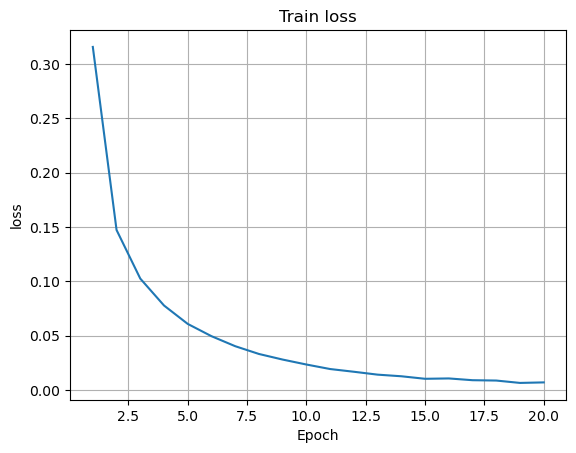

In [50]:
#model = MLP().to(DEVICE) # x_batch, y_batch, model까지 DEVICE에 올려줘야함
model = MLP()

optimizer = optim.Adam(model.parameters(), lr = LP) # model를 만들고 parameter를 받아야하니깐!

loss_history = Train(model, train_DL, criterion, optimizer)

plt.plot(range(1, EPOCH + 1), loss_history)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Train loss')
plt.grid()

## 모델 저장하기 & 불러오기


In [ ]:
save_model_path = './result/MLP_MNINT.pt'
torch.save(model.state_dict(), save_model_path)
model.state_dict()

In [56]:
load_model = MLP()
'''
load_model.load_state_dict(torch.load(save_model_path, map_location = DEVICE))
GPU로 학습 시킨거 CPU로 추론하면 오류 생길수도 있어서 map_location으로 동일 환경에서
작업되게끔 ㄱㄱ
'''
load_model.load_state_dict(torch.load(save_model_path))

<All keys matched successfully>

## 모델 테스트하기

In [112]:
def Test(model, test_DL):

    load_model.eval()

    with torch.no_grad():
        rcorrect = 0
        for x_batch, y_batch in test_DL: # GPU 메모리가 한계가 있기 때문에 test data를 한 방에 넣지 않고 일부씩만 넣기

            # inference
            y_hat = model(x_batch)

            # accurarcy accumulation
            #print(sum(y_hat[0])->?? 아 병신아 loss 구하는게 아니잖아...그냥 logit이겠지
            #print(y_hat.shape)
            #print(torch.argmax(y_hat, dim = 1)) # 이거 체크
            #print(y_batch)
            #print(y_batch == torch.argmax(y_hat, dim = 1))
            pred = y_hat.argmax(dim = 1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b
        accuracy_e = rcorrect / len(test_DL.dataset) * 100

    print(f"Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(accuracy_e,1)} %)")

In [113]:
Test(model, test_DL)

Test accuracy: 9774/10000 (97.7 %)


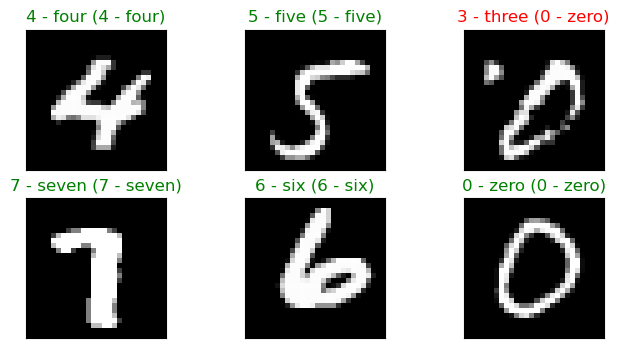

In [119]:
def Test_plot(model, test_DL):
    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_DL))
        y_hat = model(x_batch)
        pred = y_hat.argmax(dim=1)

    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx].permute(1,2,0).squeeze(), cmap="gray")
        pred_class = test_DL.dataset.classes[pred[idx]]
        true_class = test_DL.dataset.classes[y_batch[idx]]
        plt.title(f"{pred_class} ({true_class})", color = "g" if pred_class==true_class else "r")


Test_plot(load_model, test_DL)